<a href="https://colab.research.google.com/github/sushirito/Molecular-Dynamics/blob/main/bathymetry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Install essential libraries
!pip install plotly geopandas rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 95.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np

# For XYZ data (tabular format)
bathy_df = pd.read_csv('/content/Apr19_bathy_NAVD88.xyz',
                      delim_whitespace=True,
                      names=['Longitude', 'Latitude', 'Depth'])

# For ASC/Esri ASCII (gridded format)
with open('Apr19_bathy_NAVD88.asc') as f:
    ncols = int(f.readline().split()[1])
    nrows = int(f.readline().split()[1])
    xll = float(f.readline().split()[1])  # xllcorner/center
    yll = float(f.readline().split()[1])  # yllcorner/center
    cellsize = float(f.readline().split()[1])
    nodata = float(f.readline().split()[1])

    data = np.loadtxt(f, dtype=np.float32)

depth_grid = np.flipud(data)  # ASC files are top-to-bottom

<ipython-input-3-c25d3307aaee>:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  bathy_df = pd.read_csv('/content/Apr19_bathy_NAVD88.xyz',


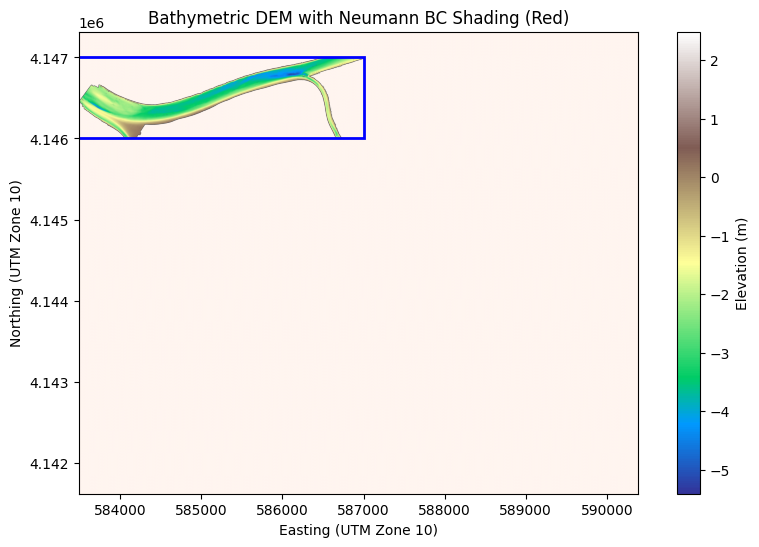

In [39]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# File path
asc_file = "/content/Apr19_bathy_NAVD88.asc"

with rasterio.open(asc_file) as dataset:
    array = dataset.read(1)
    nodata = dataset.nodata
    array[array == nodata] = np.nan

    # Get spatial extent
    transform = dataset.transform
    x_min, y_max = transform * (0, 0)
    x_max, y_min = transform * (array.shape[1], array.shape[0])

    # Generate UTM coordinate arrays
    x_coords = np.linspace(x_min, x_max, array.shape[1])
    y_coords = np.linspace(y_max, y_min, array.shape[0])
    X, Y = np.meshgrid(x_coords, y_coords)

    # Define bounding box (river region candidate)
    x_range = (583000, 587000)
    y_range = (4146000, 4147000)

    # Valid river points: inside bounding box AND non-NaN
    valid_mask = ((X >= x_range[0]) & (X <= x_range[1]) &
                  (Y >= y_range[0]) & (Y <= y_range[1]) &
                  (~np.isnan(array)))
    # Neumann BCs applied on all other points
    neumann_mask = ~valid_mask

# Plot DEM with Neumann BC overlay
plt.figure(figsize=(10, 6))
plt.imshow(array, cmap="terrain", interpolation="bilinear", origin="upper",
           extent=[x_min, x_max, y_min, y_max])
plt.colorbar(label="Elevation (m)")

# Create an overlay: value 1 for Neumann points, NaN elsewhere so they appear in red
neumann_overlay = np.where(neumann_mask, 1, np.nan)
plt.imshow(neumann_overlay, cmap="Reds", alpha=1, origin="upper",
           extent=[x_min, x_max, y_min, y_max])

# Draw the bounding box (in blue) for visual reference
rect = Rectangle((x_range[0], y_range[0]),
                 x_range[1] - x_range[0],
                 y_range[1] - y_range[0],
                 linewidth=2, edgecolor='blue', facecolor='none')
plt.gca().add_patch(rect)

plt.title("Bathymetric DEM with Neumann BC Shading (Red)")
plt.xlabel("Easting (UTM Zone 10)")
plt.ylabel("Northing (UTM Zone 10)")
plt.show()

In [41]:
!pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=76ab4dae79c902141980b29ef751ea221f76cd717c175544a587dec54c2341ef
  Stored in directory: /root/.cache/pip/wheels/84/20/8c/8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pyDOE


cuda


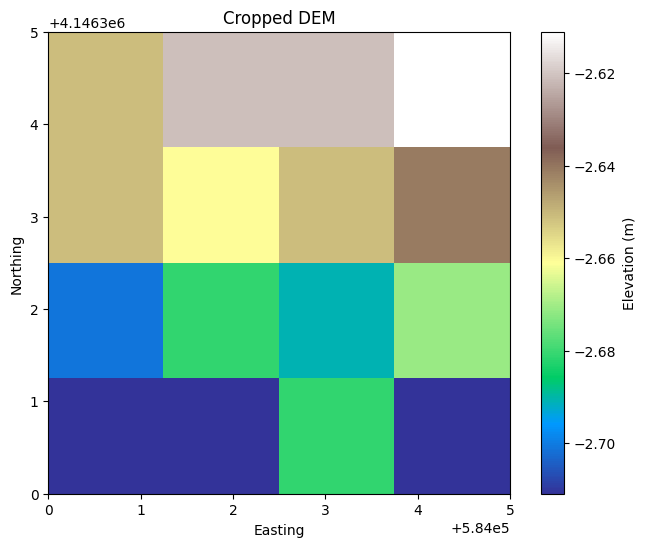

Deposit center: (584002.57, 4146304.32)
Epoch 100, Loss: 0.103522
Epoch 200, Loss: 0.000003
Epoch 300, Loss: 0.000000
Epoch 400, Loss: 0.000000
Epoch 500, Loss: 0.000000
Epoch 600, Loss: 0.000000
Epoch 700, Loss: 0.000000
Epoch 800, Loss: 0.000000
Epoch 900, Loss: 0.000000


KeyboardInterrupt: 

In [44]:
#%% Setup and Preprocessing
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import torch
import torch.nn as nn
from pyDOE import lhs
import time

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
torch.manual_seed(31)
np.random.seed(31)

# ------------------------------
# 1. Load bathymetry and define river geometry
asc_file = "/content/Apr19_bathy_NAVD88.asc"
with rasterio.open(asc_file) as dataset:
    bathy = dataset.read(1)
    nodata = dataset.nodata
    bathy[bathy == nodata] = np.nan

    transform = dataset.transform
    x_min_full, y_max_full = transform * (0, 0)
    x_max_full, y_min_full = transform * (bathy.shape[1], bathy.shape[0])

# Define bounding box for river (as provided)
#x_range = (583000, 587000)
#y_range = (4146000, 4147000)

x_range = (584000, 584005)
y_range = (4146300, 4146305)

# Create full UTM coordinate arrays for the DEM
x_coords_full = np.linspace(x_min_full, x_max_full, bathy.shape[1])
y_coords_full = np.linspace(y_max_full, y_min_full, bathy.shape[0])
X_full, Y_full = np.meshgrid(x_coords_full, y_coords_full)

# Crop to bounding box
ix = np.where((x_coords_full >= x_range[0]) & (x_coords_full <= x_range[1]))[0]
iy = np.where((y_coords_full >= y_range[0]) & (y_coords_full <= y_range[1]))[0]
bathy_crop = bathy[iy.min():iy.max(), ix.min():ix.max()]
X = X_full[iy.min():iy.max(), ix.min():ix.max()]
Y = Y_full[iy.min():iy.max(), ix.min():ix.max()]

# Valid river mask: inside bounding box and not NaN
valid_mask = ~np.isnan(bathy_crop)
valid_coords = np.column_stack((X[valid_mask], Y[valid_mask]))

# Plot to verify (optional)
plt.figure(figsize=(8,6))
plt.imshow(bathy_crop, cmap="terrain", origin="upper",
           extent=[x_range[0], x_range[1], y_range[0], y_range[1]])
plt.colorbar(label="Elevation (m)")
plt.title("Cropped DEM")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.show()

# ------------------------------
# 2. Choose a random deposit point and define the initial condition
# Parameters for Gaussian deposit:
sigma = 100.0  # spread (adjust as needed)
def deposit_IC(x, y, x0, y0):
    return np.exp(-(((x-x0)**2+(y-y0)**2)/(2*sigma**2)))

# Choose a random valid deposit center
idx0 = np.random.choice(valid_coords.shape[0])
x0, y0 = valid_coords[idx0]
print(f"Deposit center: ({x0:.2f}, {y0:.2f})")

# ------------------------------
# 3. PINN Setup and Training Data Preparation

# We now set T_final = 1.0 (nondimensionalized time) for simplicity.
T_final = 1.0

# Modified training data generator
def trainingdata_modified(Nx, Ny, Nt, Nf, Nu):
    # Spatial grid (using the bounding box) for initial condition:
    x = np.linspace(x_range[0], x_range[1], Nx)
    y = np.linspace(y_range[0], y_range[1], Ny)
    X_grid, Y_grid = np.meshgrid(x, y)
    X_flat = X_grid.flatten()[:, None]
    Y_flat = Y_grid.flatten()[:, None]

    # At t=0, assign IC only for valid (river) points:
    # For simplicity, we use nearest-neighbor check: if (x,y) is within the DEM valid region.
    # Create a KD-tree or use a simple bounding box check with the valid_mask grid:
    # Here, we assume points inside the crop are valid if they fall inside the min/max of X and Y in the crop.
    valid_xmin, valid_xmax = X[valid_mask].min(), X[valid_mask].max()
    valid_ymin, valid_ymax = Y[valid_mask].min(), Y[valid_mask].max()
    ic_valid = ((X_flat >= valid_xmin) & (X_flat <= valid_xmax) &
                (Y_flat >= valid_ymin) & (Y_flat <= valid_ymax))
    u_ic = np.zeros_like(X_flat)
    # Apply deposit function for valid initial condition points:
    u_ic[ic_valid] = deposit_IC(X_flat[ic_valid], Y_flat[ic_valid], x0, y0)

    t_ic = np.zeros_like(X_flat)
    IC_points = np.hstack((X_flat, Y_flat, t_ic))

    # Boundary data: sample points along the four sides of the rectangle for times in [0, T_final]
    Nb_side = Nx  # number of points along each side
    t_b = np.linspace(0, T_final, Nt)[:, None]
    # Left and right boundaries:
    x_left = np.full((Nb_side, 1), x_range[0])
    x_right = np.full((Nb_side, 1), x_range[1])
    y_side = np.linspace(y_range[0], y_range[1], Nb_side)[:, None]
    # Left and right boundary spatial points:
    left_points = np.hstack((x_left, y_side))
    right_points = np.hstack((x_right, y_side))
    # Bottom and top boundaries:
    y_bottom = np.full((Nb_side, 1), y_range[0])
    y_top = np.full((Nb_side, 1), y_range[1])
    x_side = np.linspace(x_range[0], x_range[1], Nb_side)[:, None]
    bottom_points = np.hstack((x_side, y_bottom))
    top_points = np.hstack((x_side, y_top))

    # Extrude boundaries in time:
    def extrude(points):
        return np.hstack((np.repeat(points, Nt, axis=0),
                          np.tile(t_b, (points.shape[0], 1))))

    bc_left = extrude(left_points)
    bc_right = extrude(right_points)
    bc_bottom = extrude(bottom_points)
    bc_top = extrude(top_points)

    # Also store the corresponding normals for each boundary:
    n_left = np.tile(np.array([[-1, 0]]), (bc_left.shape[0], 1))
    n_right = np.tile(np.array([[1, 0]]), (bc_right.shape[0], 1))
    n_bottom = np.tile(np.array([[0, -1]]), (bc_bottom.shape[0], 1))
    n_top = np.tile(np.array([[0, 1]]), (bc_top.shape[0], 1))

    bc_points = np.vstack((bc_left, bc_right, bc_bottom, bc_top))
    bc_normals = np.vstack((n_left, n_right, n_bottom, n_top))

    # PDE collocation points: sample only in the valid (river) region
    idx = np.random.choice(valid_coords.shape[0], size=Nf, replace=True)
    interior_xy = valid_coords[idx]
    t_interior = np.random.uniform(0, T_final, (Nf, 1))
    interior_points = np.hstack((interior_xy, t_interior))

    # Also include the IC points in the training of the PDE (optional)
    all_ic = IC_points[:Nu]  # sample Nu IC points

    # Shuffle the initial condition points
    perm = np.random.permutation(all_ic.shape[0])
    all_ic = all_ic[perm]
    u_ic = u_ic[perm]

    return (nptoTensor(all_ic), nptoTensor(u_ic),
            nptoTensor(bc_points), nptoTensor(bc_normals),
            nptoTensor(interior_points))

def nptoTensor(data):
    return torch.from_numpy(data).to(device).float()

# Training data parameters:
N_u = 500       # number of IC points
N_b = 4 * 30    # total boundary points (4 sides, 30 each)
N_x = 50; N_y = 50  # for IC grid (used above)
N_t = 20        # for boundary time extrusion
N_f = 10000     # interior collocation points

# Generate training data
ic_data, u_ic_data, bc_data, bc_normals_data, interior_data = trainingdata_modified(N_x, N_y, N_t, N_f, N_u)

# ------------------------------
# 4. Define the PINN Model (keeping most of your original structure)

D = 0.1  # diffusion coefficient

# --- Modified Initialization and Loss Terms ---

def nonzero_bias_init(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_normal_(module.weight)
        # Set biases to a small positive value instead of zero:
        nn.init.constant_(module.bias, 0.1)

class MLP(nn.Module):
    def __init__(self, layers):
        super(MLP, self).__init__()
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1])
                                      for i in range(len(layers)-1)])
        # Use our custom initialization:
        self.apply(nonzero_bias_init)

    def forward(self, x):
        for i in range(len(self.linears)-1):
            x = self.activation(self.linears[i](x))
        return self.linears[-1](x)

    def loss_IC(self, x_ic, u_ic):
        u_pred = self.forward(x_ic)
        return self.loss_function(u_pred, u_ic)

    def loss_interior(self, x_int):
        x_int.requires_grad = True
        u = self.forward(x_int)
        grads = torch.autograd.grad(u, x_int, grad_outputs=torch.ones_like(u),
                                    create_graph=True)[0]
        u_x = grads[:, 0:1]
        u_y = grads[:, 1:2]
        u_t = grads[:, 2:3]
        u_xx = torch.autograd.grad(u_x, x_int, grad_outputs=torch.ones_like(u_x),
                                   create_graph=True)[0][:, 0:1]
        u_yy = torch.autograd.grad(u_y, x_int, grad_outputs=torch.ones_like(u_y),
                                   create_graph=True)[0][:, 1:2]
        pde = u_t - D * (u_xx + u_yy)
        return torch.mean(pde**2)

    def loss_neumann(self, x_bc, normals):
        x_bc.requires_grad = True
        u = self.forward(x_bc)
        grads = torch.autograd.grad(u, x_bc, grad_outputs=torch.ones_like(u),
                                    create_graph=True)[0]
        grad_xy = grads[:, :2]
        neumann_val = torch.sum(grad_xy * normals, dim=1, keepdim=True)
        return torch.mean(neumann_val**2)

    # New: Mass balance loss over a given grid at time t_val
    def loss_mass_balance(self, t_val, grid_x, grid_y, initial_mass):
        X, Y = np.meshgrid(grid_x, grid_y)
        T = t_val * np.ones_like(X)
        points = np.hstack((X.flatten()[:, None], Y.flatten()[:, None], T.flatten()[:, None]))
        points_tensor = nptoTensor(points)
        with torch.no_grad():
            u_pred = self.forward(points_tensor)
        # Approximate integration over domain (dx*dy factor)
        dx = (grid_x[-1]-grid_x[0])/(len(grid_x)-1)
        dy = (grid_y[-1]-grid_y[0])/(len(grid_y)-1)
        mass_pred = torch.sum(u_pred) * dx * dy
        return (mass_pred - initial_mass)**2

    def total_loss(self, x_ic, u_ic, x_int, x_bc, normals,
                   grid_x, grid_y, initial_mass, weights):
        loss_ic = self.loss_IC(x_ic, u_ic)
        loss_int = self.loss_interior(x_int)
        loss_bc  = self.loss_neumann(x_bc, normals)
        loss_mass = self.loss_mass_balance(t_val=0.5, grid_x=grid_x, grid_y=grid_y,
                                           initial_mass=initial_mass)
        return (weights['ic']*loss_ic + weights['int']*loss_int +
                weights['bc']*loss_bc + weights['mass']*loss_mass)

# --- Define domain for mass integration (5x5 grid) ---
Nx_eval, Ny_eval = 50, 50
x_eval = np.linspace(x_range[0], x_range[1], Nx_eval)
y_eval = np.linspace(y_range[0], y_range[1], Ny_eval)

# --- Compute initial mass from deposit (using the IC grid) ---
# Assuming ic_data (x_ic, u_ic) from your training data generation:
initial_mass = torch.sum(u_ic_data).item() * ((x_range[1]-x_range[0])/(N_x-1))**2

# --- Set loss weights (tune as needed) ---
weights = {'ic': 1.0, 'int': 1.0, 'bc': 10.0, 'mass': 10.0}

# --- Model and Optimizer ---
neurons = 50
layers = [3] + [neurons]*10 + [1]
mlp = MLP(layers).to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)

# --- Training Loop ---
max_iter = 1500
loss_history = []
tic = time.time()

for i in range(max_iter):
    optimizer.zero_grad()
    loss = mlp.total_loss(ic_data, u_ic_data, interior_data,
                          bc_data, bc_normals_data,
                          x_eval, y_eval, initial_mass, weights)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if (i+1) % 100 == 0:
        print(f"Epoch {i+1}, Loss: {loss.item():.6f}")

toc = time.time()
print(f"Total training time: {(toc-tic)/60:.2f} minutes")


# ------------------------------
# 6. Evaluation and Plotting evolution over time
def eval_model(model, x, y, t):
    # x, y, t are 2D arrays; we flatten and evaluate then reshape
    X_flat = x.flatten()[:, None]
    Y_flat = y.flatten()[:, None]
    T_flat = t.flatten()[:, None]
    inp = np.hstack((X_flat, Y_flat, T_flat))
    inp_tensor = nptoTensor(inp)
    with torch.no_grad():
        u_pred = model(inp_tensor).cpu().numpy()
    return u_pred.reshape(x.shape)

# Create a grid for evaluation (use the valid bounding box)
Nx_eval, Ny_eval = 100, 100
x_eval = np.linspace(x_range[0], x_range[1], Nx_eval)
y_eval = np.linspace(y_range[0], y_range[1], Ny_eval)
X_eval, Y_eval = np.meshgrid(x_eval, y_eval)

# Plot evolution at a few time snapshots
times_to_plot = [0.0, 0.25, 0.5, 0.75, 1.0]
fig, axes = plt.subplots(1, len(times_to_plot), figsize=(20,4))
for i, t_val in enumerate(times_to_plot):
    T_eval = t_val * np.ones_like(X_eval)
    U_pred = eval_model(mlp, X_eval, Y_eval, T_eval)
    im = axes[i].imshow(U_pred, cmap="viridis", origin="lower",
                   extent=[x_range[0], x_range[1], y_range[0], y_range[1]])
    axes[i].set_title(f"t = {t_val:.2f}")
    axes[i].set_xlabel("Easting")
    axes[i].set_ylabel("Northing")
    # Optional: overlay the river boundary (valid region) as a contour
    axes[i].contour(X, Y, valid_mask.astype(float), levels=[0.5], colors='red', linewidths=2)
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5, label="Solute concentration")
plt.suptitle("Evolution of Solute via PINN (Neumann BC on river edges)")
plt.show()
